In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import descartes

%matplotlib inline

In [2]:
train_df = pd.read_csv('./kaggle_data/train.csv')
weather_df = pd.read_csv('./kaggle_data/weather.csv')
spray_df = pd.read_csv('./kaggle_data/spray.csv')

In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [4]:
geometry = [Point(xy) for xy in zip(spray_df.Longitude, spray_df.Latitude)]

In [5]:
spray_df['geometry'] = geometry

In [6]:
spray_df.drop(['Latitude','Longitude'], axis = 1, inplace=True)

In [7]:
crs = {'init': 'epsg:4326'}
spray_locs = gpd.GeoDataFrame(spray_df, crs=crs, geometry=geometry)

In [8]:
spray_locs.head()

Date        Time                                    geometry
0  2011-08-29  6:56:58 PM  POINT (-88.0891633333333 42.3916233333333)
1  2011-08-29  6:57:08 PM  POINT (-88.0891633333333 42.3913483333333)
2  2011-08-29  6:57:18 PM  POINT (-88.0891566666667 42.3910216666667)
3  2011-08-29  6:57:28 PM  POINT (-88.0891583333333 42.3906366666667)
4  2011-08-29  6:57:38 PM         POINT (-88.08885833333331 42.39041)

In [9]:
city_bound = gpd.read_file("./chicago_geodata/geo_export_55fcb48c-7621-4c8a-999c-9fb3c86e8950.shp")

In [10]:
train_geo = [Point(xy) for xy in zip(train_df.Longitude, train_df.Latitude)]

In [11]:
train_df['location'] = train_geo

In [12]:
train_df.drop(['Latitude','Longitude'], axis = 1, inplace=True)

In [13]:
mosquito_locs = gpd.GeoDataFrame(train_df, crs=crs, geometry=train_geo)

In [14]:
#need to remove outlier data on plot, would be good if we can drop all data that is outside of the city lines

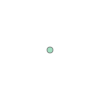

In [15]:
mosquito_locs.location[2]

In [16]:
city_bound.contains(mosquito_locs.location[1])

0    True
dtype: bool

In [43]:
street_map = gpd.read_file('/home/ryan/Downloads/geo_export_1525534b-b713-44d0-abb6-b80b5d009726.shp')

In [17]:
def location_check(list_of_points, boundary):
    in_boundary = []
    counter = 0
    for i in list_of_points:
        while counter < len(list_of_points):
            if boundary.contains(list_of_points[counter])[0]:
                in_boundary.append(1)
            else:
                in_boundary.append(0)
            counter += 1
    return in_boundary
            

In [18]:
mosq_incity = location_check(mosquito_locs.location, city_bound)

In [19]:
spray_incity = location_check(spray_locs.geometry, city_bound)

In [20]:
mosquito_locs['mosq_incity'] = mosq_incity

In [21]:
mosquito_locs = mosquito_locs[mosquito_locs['mosq_incity'] == 1]

In [22]:
spray_locs.shape

(14835, 3)

In [23]:
spray_locs['spray_incity'] = spray_incity

In [24]:
spray_locs = spray_locs[spray_locs['spray_incity'] == 1]

In [25]:
spray_locs.shape

(14666, 4)

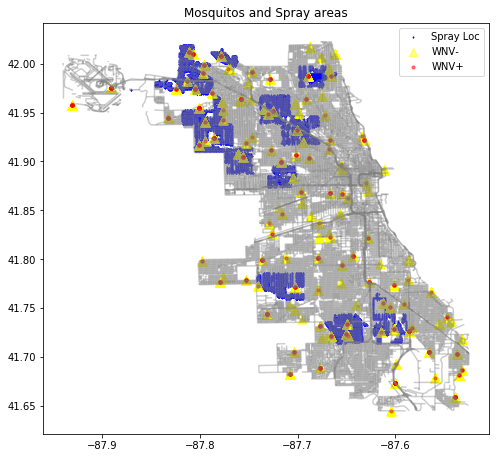

In [44]:
fig, ax = plt.subplots(figsize = (8,8))
spray_locs.geometry.plot(marker='d', color='blue', markersize=1, ax=ax, label = 'Spray Loc')
street_map.plot(color='grey', ax=ax, alpha = 0.4)
mosquito_locs[mosquito_locs['WnvPresent']==0].geometry.plot(marker='^', color = 'yellow', ax = ax, label = 'WNV-', alpha=.5, markersize = 75 )
mosquito_locs[mosquito_locs['WnvPresent']==1].geometry.plot(marker='o', color = 'red', ax = ax, label = 'WNV+', alpha = .5, markersize = 10)
# at first glance, it looks as though WNV- mosquitos were found alongside WNV+ mosquitos everytime a WNV+ mosquito was found
    #however, there are lots of instances where WNV- mosquitos were found with WNV+ mosquitos


plt.title('Mosquitos and Spray areas')
plt.legend()

In [55]:
predicted_locs = pd.read_csv('./best_wnv_locations.csv')

In [34]:
predicted_geo = [Point(xy) for xy in zip(predicted_locs.Longitude, predicted_locs.Latitude)]

In [57]:
predicted_locs['location'] = predicted_geo

In [58]:
predicted_locs.drop(['Latitude','Longitude'], axis =1, inplace = True)

In [59]:
predicted_locs = gpd.GeoDataFrame(predicted_locs, crs=crs, geometry=predicted_geo)

In [60]:
predicted_locs.drop(['Unnamed: 0', 'Preds', 'location'], axis=1, inplace=True)

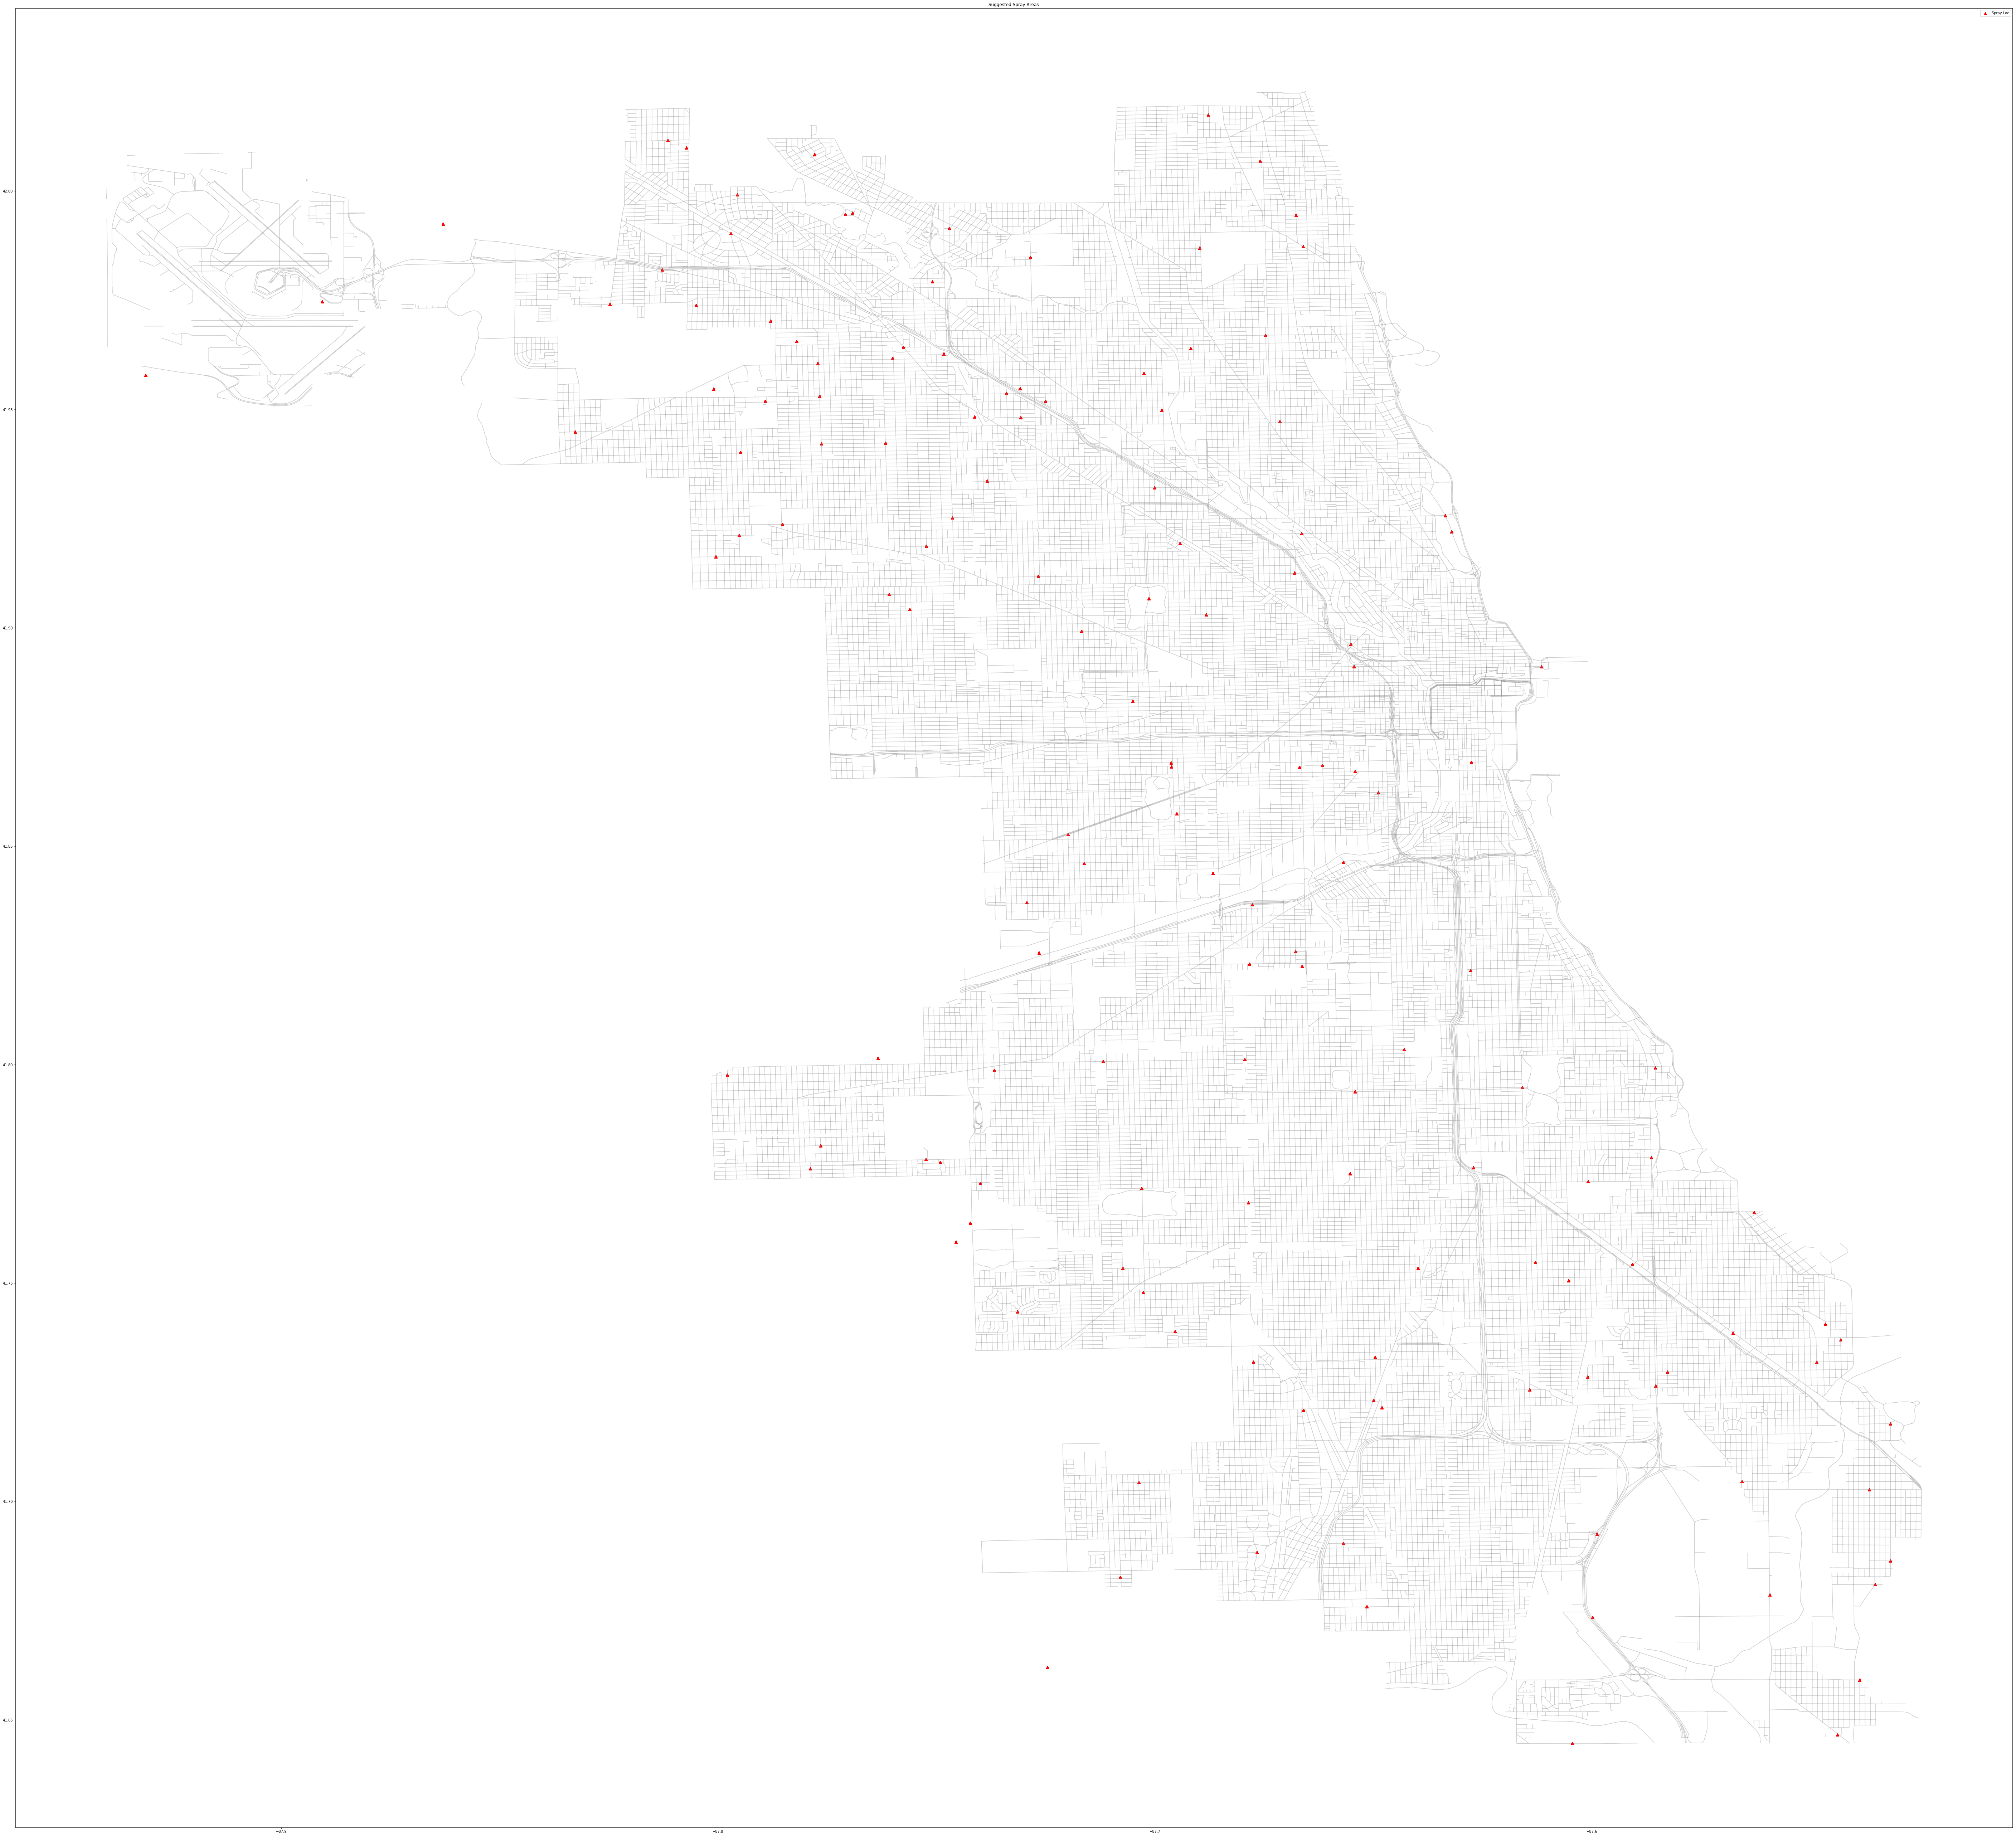

In [62]:
fig, ax = plt.subplots(figsize = (100,100))
street_map.plot(color='grey', ax=ax, alpha = 0.4)
predicted_locs.geometry.plot(marker='^', color='red', markersize=55, ax=ax, label = 'Spray Loc')

plt.title('Suggested Spray Areas')
plt.legend()
plt.savefig('./suggested_spray_map.jpg')